# 火山科学島原実習
３点の地震計アレイ観測により，地震波（常時微動）の到来方向とみかけ速度を推定する．

Google Colaboratoryを利用する場合は，最初に以下のセルを実行し，obspyをインストールする．ランタイムがリセットされたら，再び実行する必要がある．

In [ ]:
# Colaboratoryで最初に起動したときに実行
!pip install obspy

### 必要なパッケージを読み込む
readwin.py と lonlat2xy は同じフォルダーに入れておく．

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from obspy import Stream, UTCDateTime
from IPython.display import clear_output
import readwin, lonlat2xy
from scipy import signal

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['pdf.fonttype'] = 42

### パラメータの設定

In [3]:
# データ（winファイル）が存在するフォルダー
# 地震計1,2,3に対してそれぞれ指定
datadir1 = './data/0813821014/220628/'
datadir2 = './data/0970355145/220628/'
datadir3 = './data/0970355152/220628/'

# 使用する時間範囲
# 全ての観測点でデータが存在している時間を指定
date1 = UTCDateTime('2022-06-28T13:45:00')
date2 = UTCDateTime('2022-06-28T14:10:00')

# バンドパスフィルターの周波数
f1 = 0.5
f2 = 1

# 観測点1,2,3の経度（longitude）と緯度（latitude）
lon1 = 130.360393
lat1 = 32.773520
lon2 = 130.360351
lat2 = 32.773190
lon3 = 130.360051
lat3 = 32.773416

# 平面（xy）に投影する際の原点座標（どれか一つの観測点でも，アレイ付近の任意の座標でもOK）
lon_ref = 130.360220
lat_ref = 32.773251


### フィルターの定義とデータの読み込み

In [4]:
def filter(f1, f2, st):
    st.detrend(type='constant')
    st.taper(type='cosine', max_percentage=0.04)
    st.filter('bandpass', freqmin=f1, freqmax=f2, zerophase=True)

In [5]:
# 地震計1,2,3のデータをそれぞれ読み込む．
# 上で指定したフォルダ内の全てのwinファイルを読み込む．
# ObsPyのStreamオブジェクトとして読み込まれる．
st1 = readwin.read_win(datadir1 + '*win')
st2 = readwin.read_win(datadir2 + '*win')
st3 = readwin.read_win(datadir3 + '*win')

# 使用する範囲のデータを切り出す
# 短すぎないほうがいい
st1.trim(date1, date2)
st2.trim(date1, date2)
st3.trim(date1, date2)

# バンドパスフィルターを適用する
filter(f1, f2, st1)
filter(f1, f2, st2)
filter(f1, f2, st3)

# Streamオブジェクトからデータ（ndarray）を取り出す
# 取り出したいチャンネル番号を指定
wave1 = st1.select(channel='a003')[0].data
wave2 = st2.select(channel='b003')[0].data
wave3 = st3.select(channel='c003')[0].data

# Streamオブジェクトの中から情報を取り出す
stats = st1.select(channel='a003')[0].stats
dt = stats.delta    # サンプリング間隔
npts = stats.npts   # サンプル数（データの個数）
t = np.arange(stats.npts)*stats.delta   # 時間軸の作成


### データをプロットしてみる

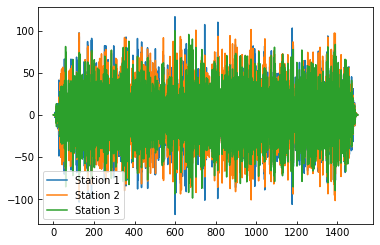

In [6]:
plt.plot(t, wave1, label='Station 1')
plt.plot(t, wave2, label='Station 2')
plt.plot(t, wave3, label='Station 3')
plt.legend()

### ノイズの中から全観測点に共通で似ている波を探す
読み込んだデータをある時間窓（window秒）ごと順番にプロットする．  
エンターを押すことで次の時刻（窓）へ進む．  
途中で止める時には esc を押す．

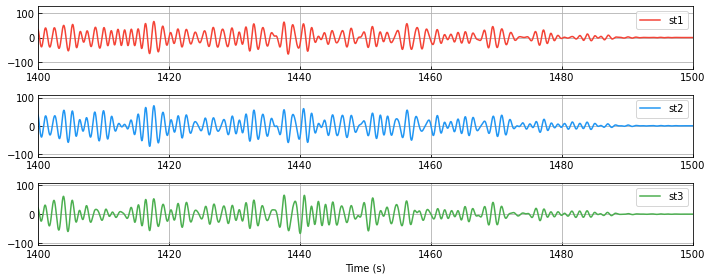

In [6]:
window = 100
n_window = int((date2 - date1)/window)

for i in range(n_window):
    t1 = i*window
    t2 = t1 + window
    fig = plt.figure(figsize=(10,4),tight_layout=True)
    ax1 = fig.add_subplot(3,1,1)
    ax1.plot(t, wave1, color='#F44336', label='st1')
    ax1.set_xlim(t1, t2)
    ax1.grid()
    ax1.legend()
    ax2 = fig.add_subplot(3,1,2)
    ax2.plot(t, wave2, color='#2196F3', label='st2')
    ax2.set_xlim(t1, t2)
    ax2.grid()
    ax2.legend()
    ax3 = fig.add_subplot(3,1,3)
    ax3.plot(t, wave3, color='#4CAF50', label='st3')
    ax3.set_xlim(t1, t2)
    ax3.grid()
    ax3.legend()
    ax3.set_xlabel('Time (s)')
    plt.show()
    input()
    clear_output(True)


### 波形の一部を切り出す
切り出す際には端の影響を軽減するために，コサインテーパー（tukey窓）をかけて両端を滑らかに落とす．

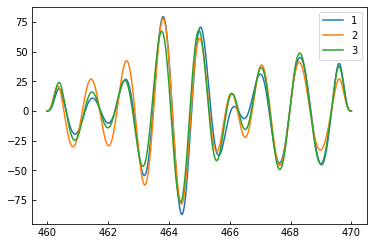

In [7]:
# 切り出す時間窓の設定
t1_cut = 460
t2_cut = 470
nt_cut = int((t2_cut-t1_cut)/dt)+1
t = np.arange(nt_cut)*dt + t1_cut

# コサインテーパー（tukey窓関数）
# 両端のそれぞれ0.5%の部分を滑らかに落とす
window = signal.tukey(nt_cut, alpha=0.1)

# コサインテーパーをかけてプロット
it1_cut = int(t1_cut/dt)
cut1 = wave1[it1_cut:it1_cut+nt_cut]*window
cut2 = wave2[it1_cut:it1_cut+nt_cut]*window
cut3 = wave3[it1_cut:it1_cut+nt_cut]*window
plt.plot(t, cut1, label='1')
plt.plot(t, cut2, label='2')
plt.plot(t, cut3, label='3')
plt.legend()

### 相互相関関数を計算する
まずは2つの時系列の規格化した相互相関関数を計算する関数を定義

In [8]:
def cal_correlation(data1, data2, dt):
    ccf = np.correlate(data1, data2, mode='same')
    cc11 = np.correlate(data1, data1)   # np.sum(data1**2)と同じ
    cc22 = np.correlate(data2, data2)
    ccf /= np.sqrt(cc11*cc22)   # 規格化
    lag = np.arange(len(ccf))*dt - (len(ccf)//2)*dt
    return lag, ccf # ラグタイムの配列と相互相関関数を返す


観測点1,2,3の相互相関関数を計算する．  
定義より，例えば上の関数に観測点1，観測点2の順番で与えた場合，観測点1から2への経過時間（観測点2がどれだけ遅れているか）が，負のラグタイムにピークを持つ．

station 1 - 2
  peak: 0.9586190707576715
  lag: 0.008000000000000007 (s)

station 2 - 3
  peak: 0.9637713255460002
  lag: 0.02400000000000002 (s)

station 3 - 1
  peak: 0.9810758178556083
  lag: -0.03599999999999959 (s)


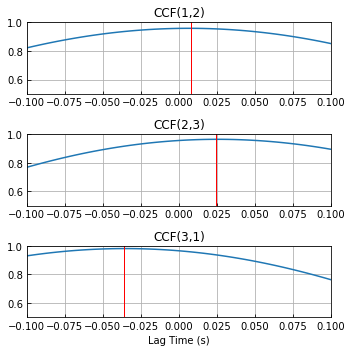

In [9]:
# それぞれのペアの相互相関関数の計算
lag, cc12 = cal_correlation(cut1, cut2, dt)
_, cc23 = cal_correlation(cut2, cut3, dt)
_, cc31 = cal_correlation(cut3, cut1, dt)

# 相互相関関数が最大になるラグとその時の値を表示する
lag_12 = lag[np.argmax(cc12)]
lag_23 = lag[np.argmax(cc23)]
lag_31 = lag[np.argmax(cc31)]
print('station 1 - 2')
print('  peak:', cc12[np.argmax(cc12)])
print('  lag:', lag_12, '(s)')
print('')
print('station 2 - 3')
print('  peak:', cc23[np.argmax(cc23)])
print('  lag:', lag_23, '(s)')
print('')
print('station 3 - 1')
print('  peak:', cc31[np.argmax(cc31)])
print('  lag:', lag_31, '(s)')

# プロットする
fig = plt.figure(figsize=(5,5), tight_layout=True)
ax1 = fig.add_subplot(3,1,1)
ax1.plot(lag, cc12)
ax1.axvline(x=lag_12, color='red', linewidth=1)
ax1.set_title('CCF(1,2)')
ax1.set_xlim(-0.1,0.1)
ax1.set_ylim(0.5, 1)
ax1.grid()
ax2 = fig.add_subplot(3,1,2)
ax2.plot(lag, cc23)
ax2.axvline(x=lag_23, color='red', linewidth=1)
ax2.set_title('CCF(2,3)')
ax2.set_xlim(-0.1,0.1)
ax2.set_ylim(0.5, 1)
ax2.grid()
ax3 = fig.add_subplot(3,1,3)
ax3.plot(lag, cc31)
ax3.axvline(x=lag_31, color='red', linewidth=1)
ax3.set_title('CCF(3,1)')
ax3.set_xlim(-0.1,0.1)
ax3.set_ylim(0.5, 1)
ax3.set_xlabel('Lag Time (s)')
ax3.grid()

### 観測点の位置をプロットする
x軸の正が東，y軸の正が北になるようにしている．  
緯度・経度から平面座標に変換する関数は lonlat2xy.py の中で定義している．

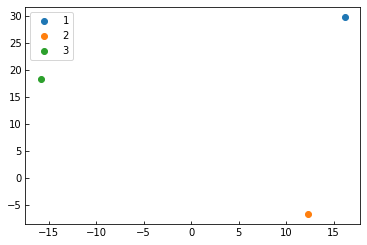

In [10]:
xy1 = lonlat2xy.lonlat2xy(lon1, lat1, lon_ref, lat_ref)
xy2 = lonlat2xy.lonlat2xy(lon2, lat2, lon_ref, lat_ref)
xy3 = lonlat2xy.lonlat2xy(lon3, lat3, lon_ref, lat_ref)
plt.scatter(xy1[0], xy1[1], label='1')
plt.scatter(xy2[0], xy2[1], label='2')
plt.scatter(xy3[0], xy3[1], label='3')
plt.legend()
plt.show()


### スローネスベクトルを求めてみよう
スローネスベクトルから波の伝播方向とみかけ速度を求めてみよう
$$
    \left[\begin{array}{c}
        t_3 - t_1 \\
        t_2 - t_1 \\
    \end{array}\right]
    = \left[\begin{array}{cc}
        x_3-x_1 & y_3-y_1 \\
        x_2-x_1 & y_2-y_1 \\
    \end{array}\right]\left[\begin{array}{c}
        s_x \\
        s_y \\
    \end{array}\right]
$$
を解いて，スローネス$\boldsymbol{s}$を求める．  
ラグタイムの符号に注意．

### 行列計算
たとえば
$$
    \begin{split}
    \left[\begin{array}{c}
        3 \\
        2 \\
    \end{array}\right]
    &= \left[\begin{array}{cc}
        1 & 5 \\
        2 & 3 \\
    \end{array}\right]\left[\begin{array}{c}
        x \\
        y \\
    \end{array}\right] \\
    A &= BX
    \end{split}
$$
を解く場合、


In [23]:
# 行列Aを定義
A = np.matrix([[3], [2]])
# 行列Bを定義
B = np.matrix([[1,5], [2, 3]])
# Bの逆行列
Bi = np.linalg.inv(B)

X = np.dot(Bi, A)

# ここまでが3年生への配布用

### 連立方程式を解いてスローネスを求める

In [11]:
A = np.matrix([[xy3[0]-xy1[0],xy3[1]-xy1[1]], [xy2[0]-xy1[0], xy2[1]-xy1[1]]])
Ai = np.linalg.inv(A)
lag = np.matrix([[lag_31], [-lag_12]])
s = np.dot(Ai, lag)
v = 1/np.sqrt(s[0,0]**2+s[1,0]**2)
az = np.arctan2(s[0,0], s[1,0])
print('Apparent Velocity:', v, '(m/s)')
print('Propagation Direction:', np.rad2deg(az))

Apparent Velocity: 915.95893604797 (m/s)
Propagation Direction: 84.65276385046592


### 結果のプロット
伝播方向と見かけ速度を極座標でプロット

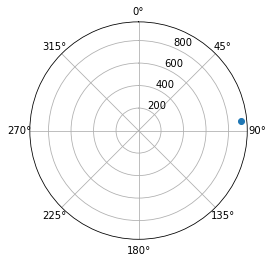

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, polar=True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')
ax.scatter(az, v)
plt.show()

### すべての時間帯で計算
時間窓を手動では選ばず，とりあえず計算して相関係数が高いところだけの結果を用いる．

In [32]:
def cal_correlation_lag_multi(window_duration, t1, t2, overlap, cc_min):
    """
    ある期間の複数の時間窓で相互相関関数を計算する．
    
    Parameters
    ----------
    window_duration : float
        一つの時間窓の長さ（秒）
    t1 : float
        期間の開始時刻（秒）
    t2 : float
        期間の終了時刻（秒）．この時刻を超えない範囲で時間窓が設定される．
    overlap : float
        時間窓を前の時間窓と重ねて設定したい場合に設定する（秒）
    cc_min : float
        結果として抜き出す最小の相互相関係数．すべてのペアでこの値を超えた場合のみ採用．

    Returns
    -------
    lag_12 : [float]
        観測点1と2のラグタイム（秒）の配列
    lag_23 : [float]
        観測点2と3のラグタイム（秒）の配列
    lag_31 : [float]
        観測点3と1のラグタイム（秒）の配列
    window_time : [float]
        相互相関が閾値を超えた時刻（秒）の配列
    """
    n_window = int((t2-t1-overlap)/(window_duration-overlap))
    nt_cut = int((window_duration)/dt)+1
    window_func = signal.tukey(nt_cut, alpha=0.1)
    lag_12 = []
    lag_23 = []
    lag_31 = []
    window_time = []
    lag = np.arange(nt_cut)*dt - (nt_cut//2)*dt

    for i in range(n_window):
        i1 = int((t1+i*(window_duration-overlap))/dt)
        cut1 = wave1[i1:i1+nt_cut]*window_func
        cut2 = wave2[i1:i1+nt_cut]*window_func
        cut3 = wave3[i1:i1+nt_cut]*window_func
        _, cc12 = cal_correlation(cut1, cut2, dt)
        _, cc23 = cal_correlation(cut2, cut3, dt)
        _, cc31 = cal_correlation(cut3, cut1, dt)
        if((np.max(cc12)>=cc_min) & (np.max(cc23)>=cc_min) & (np.max(cc31)>=cc_min)):
            lag_12.append(lag[np.argmax(cc12)])
            lag_23.append(lag[np.argmax(cc23)])
            lag_31.append(lag[np.argmax(cc31)])
            window_time.append((i1+0.5*nt_cut)*dt)

    return np.array(lag_12), np.array(lag_23), np.array(lag_31), np.array(window_time)
    
# スローネスベクトルを推定する
def estimate_s(lag_12, lag_31):
    A = np.matrix([[xy3[0]-xy1[0],xy3[1]-xy1[1]], [xy2[0]-xy1[0], xy2[1]-xy1[1]]])
    Ai = np.linalg.inv(A)
    v = np.zeros(len(lag_12))
    az = np.zeros(len(lag_12))
    for i in range(len(lag_12)):
        lag = np.matrix([[lag_31[i]], [-lag_12[i]]])
        s = np.dot(Ai, lag)
        v[i] = 1/np.sqrt(s[0,0]**2+s[1,0]**2)
        az[i] = np.arctan2(s[0,0], s[1,0])
    return v, az

In [33]:
window_duration = 10 # 各時間窓の長さ（秒）
t1 = 100 # 開始時刻（秒）
t2 = 1000 # 終了時刻（秒）
overlap = 0 # 時間窓のオーバーラップ（重なり）（秒）
cc_min = 0.7 # 最小の相互相関係数
lag_12, lag_23, lag_31, window_time = cal_correlation_lag_multi(window_duration, t1, t2, overlap, cc_min)
v, az = estimate_s(lag_12, lag_31)


/var/folders/4p/g_0_lnf50yv85k0qf7lpj_400000gn/T/ipykernel_53658/2962225897.py:63: RuntimeWarning: divide by zero encountered in double_scalars
  v[i] = 1/np.sqrt(s[0,0]**2+s[1,0]**2)


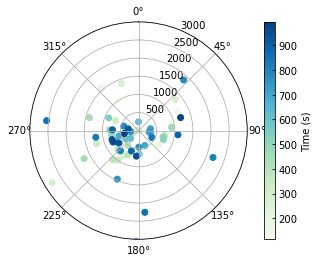

In [36]:
# 結果の表示
fig = plt.figure()
ax = fig.add_subplot(1,1,1, polar=True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location('N')
scat = ax.scatter(az, v, c=window_time, cmap='GnBu')
ax.set_rmax(3000)
cbar = fig.colorbar(scat)
cbar.set_label('Time (s)')
plt.show()

### パーティクルモーションをプロットしてみる

In [175]:
def cal_max_axis(data1, data2):
    max1 = np.max(np.abs(data1))
    max2 = np.max(np.abs(data2))
    max_asis = np.max([max1, max2])
    return max_asis

def plot_particle_motion(udnsew, t):
    fig, ax = plt.subplots(1, 3, figsize=(10,5))
    ix = [0, 0, 2]
    iy = [1, 2, 1]
    label = ['UD', 'NS', 'EW']
    for i in range(3):
        ax[i].set_aspect('equal')
        max_axis = cal_max_axis(udnsew[ix[i]], udnsew[iy[i]])
        scat = ax[i].scatter(udnsew[ix[i]], udnsew[iy[i]], c=t, cmap='jet', s=1)
        ax[i].set_xlim(-max_axis, max_axis)
        ax[i].set_ylim(-max_axis, max_axis)
        ax[i].set_xlabel(label[ix[i]])
        ax[i].set_ylabel(label[iy[i]])

    fig.subplots_adjust(right=0.8, wspace=0.35)
    cbar_ax = fig.add_axes([0.85, 0.32, 0.015, 0.36])
    fig.colorbar(scat, cax=cbar_ax)

    plt.show()

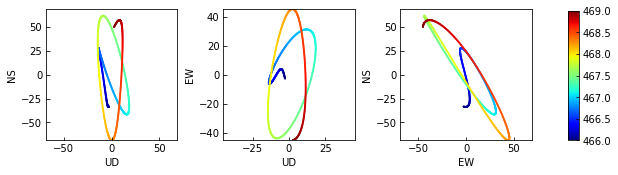

In [177]:
t1_cut = 466
t2_cut = 469
nt_cut = int((t2_cut-t1_cut)/dt)+1
t = np.arange(nt_cut)*dt + t1_cut

udnsew = np.zeros([3,nt_cut])
it1_cut = int(t1_cut/dt)
cut1 = wave1[it1_cut:it1_cut+nt_cut]
udnsew[0] = st1.select(channel='a001')[0].data[it1_cut:it1_cut+nt_cut]
udnsew[1] = st1.select(channel='a002')[0].data[it1_cut:it1_cut+nt_cut]
udnsew[2] = st1.select(channel='a003')[0].data[it1_cut:it1_cut+nt_cut]
plot_particle_motion(udnsew, t)

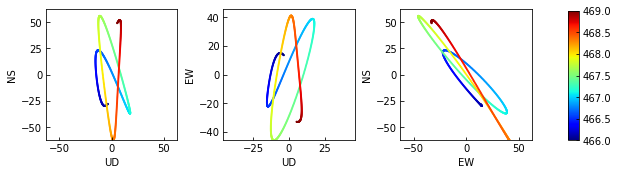

In [179]:
udnsew[0] = st2.select(channel='b001')[0].data[it1_cut:it1_cut+nt_cut]
udnsew[1] = st2.select(channel='b002')[0].data[it1_cut:it1_cut+nt_cut]
udnsew[2] = st2.select(channel='b003')[0].data[it1_cut:it1_cut+nt_cut]
plot_particle_motion(udnsew, t)

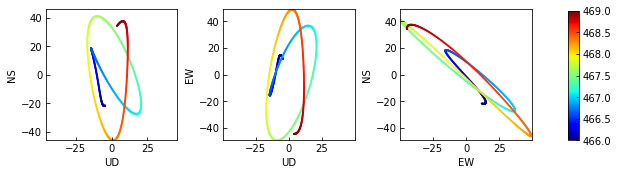

In [180]:
udnsew[0] = st3.select(channel='c001')[0].data[it1_cut:it1_cut+nt_cut]
udnsew[1] = st3.select(channel='c002')[0].data[it1_cut:it1_cut+nt_cut]
udnsew[2] = st3.select(channel='c003')[0].data[it1_cut:it1_cut+nt_cut]
plot_particle_motion(udnsew, t)